# Ciência de Dados
## Prof. Jean Paul Barddal


## Regras de associação

In [ ]:
import pandas as pd
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

### Download da base de dados

In [ ]:
df = pd.read_csv('http://www.ppgia.pucpr.br/~jean.barddal/datascience/basket_france.csv')

In [ ]:
df.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536370,22728,ALARM CLOCK BAKELIKE PINK,24,01/12/10 08:45,3.75,12583.0,France
1,536370,22727,ALARM CLOCK BAKELIKE RED,24,01/12/10 08:45,3.75,12583.0,France
2,536370,22726,ALARM CLOCK BAKELIKE GREEN,12,01/12/10 08:45,3.75,12583.0,France


### Preparação dos dados

In [ ]:
df['Description'] = df['Description'].str.strip().replace(' ', '_', regex=True)
df.dropna(axis=0, subset=['InvoiceNo'], inplace=True)
df['InvoiceNo'] = df['InvoiceNo'].astype('str')
df = df[~df['InvoiceNo'].str.contains('C')]

In [ ]:
basket = (df
          .groupby(['InvoiceNo', 'Description'])['Quantity']
          .sum().unstack().reset_index().fillna(0)
          .set_index('InvoiceNo'))

In [ ]:
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

basket_sets = basket.applymap(encode_units)
basket_sets.drop('POSTAGE', inplace=True, axis=1)

In [ ]:
# aplicar algoritmo apriori
basket_sets.head(3)
frequent_itemsets = apriori(basket_sets, min_support=0.05, use_colnames=True)


In [ ]:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules = rules[['antecedents', 'consequents', 'support', 'confidence']]
rules.head()

,antecedents,consequents,support,confidence
0,(ALARM_CLOCK_BAKELIKE_PINK),(ALARM_CLOCK_BAKELIKE_GREEN),0.073980,0.725000
1,(ALARM_CLOCK_BAKELIKE_GREEN),(ALARM_CLOCK_BAKELIKE_PINK),0.073980,0.763158
2,(ALARM_CLOCK_BAKELIKE_RED),(ALARM_CLOCK_BAKELIKE_GREEN),0.079082,0.837838
3,(ALARM_CLOCK_BAKELIKE_GREEN),(ALARM_CLOCK_BAKELIKE_RED),0.079082,0.815789
4,(ALARM_CLOCK_BAKELIKE_RED),(ALARM_CLOCK_BAKELIKE_PINK),0.073980,0.783784


In [ ]:
rules.sort_values(['support', 'confidence'], ascending=[False,False]).head(10)

,antecedents,consequents,support,confidence
67,(SET/6_RED_SPOTTY_PAPER_PLATES),(SET/6_RED_SPOTTY_PAPER_CUPS),0.122449,0.960000
66,(SET/6_RED_SPOTTY_PAPER_CUPS),(SET/6_RED_SPOTTY_PAPER_PLATES),0.122449,0.888889
53,(PLASTERS_IN_TIN_SPACEBOY),(PLASTERS_IN_TIN_WOODLAND_ANIMALS),0.104592,0.759259
52,(PLASTERS_IN_TIN_WOODLAND_ANIMALS),(PLASTERS_IN_TIN_SPACEBOY),0.104592,0.611940
65,(SET/6_RED_SPOTTY_PAPER_PLATES),(SET/20_RED_RETROSPOT_PAPER_NAPKINS),0.102041,0.800000
63,(SET/20_RED_RETROSPOT_PAPER_NAPKINS),(SET/6_RED_SPOTTY_PAPER_CUPS),0.102041,0.769231
64,(SET/20_RED_RETROSPOT_PAPER_NAPKINS),(SET/6_RED_SPOTTY_PAPER_PLATES),0.102041,0.769231
62,(SET/6_RED_SPOTTY_PAPER_CUPS),(SET/20_RED_RETROSPOT_PAPER_NAPKINS),0.102041,0.740741
45,(PLASTERS_IN_TIN_CIRCUS_PARADE),(PLASTERS_IN_TIN_WOODLAND_ANIMALS),0.102041,0.606061
44,(PLASTERS_IN_TIN_WOODLAND_ANIMALS),(PLASTERS_IN_TIN_CIRCUS_PARADE),0.102041,0.597015


## Análise exploratória de dados - Kobe Bryant

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle, Arc
import seaborn as sns

### Download da base de dados

In [ ]:
df = pd.read_csv('http://www.ppgia.pucpr.br/~jean.barddal/datascience/kobe_shots.csv.zip', compression='zip')

In [ ]:
df.head(1)

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,playoffs,season,seconds_remaining,shot_distance,shot_made_flag,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
0,Jump Shot,Jump Shot,10,20000012,33.9723,167,72,-118.1028,10,1,0,2000-01,27,18,NaN,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,1


In [ ]:
df = df[~df['shot_made_flag'].isna()]
df.drop(['game_id', 'team_id', 'matchup', 'team_name', 'shot_id'], axis=1, inplace=True)

In [ ]:
df.head(3)

,action_type,combined_shot_type,game_event_id,lat,loc_x,loc_y,lon,minutes_remaining,period,playoffs,season,seconds_remaining,shot_distance,shot_made_flag,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,game_date,opponent
1,Jump Shot,Jump Shot,12,34.0443,-157,0,-118.4268,10,1,0,2000-01,22,15,0.0,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,2000-10-31,POR
2,Jump Shot,Jump Shot,35,33.9093,-101,135,-118.3708,7,1,0,2000-01,45,16,1.0,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,2000-10-31,POR
3,Jump Shot,Jump Shot,43,33.8693,138,175,-118.1318,6,1,0,2000-01,52,22,0.0,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,2000-10-31,POR


### Questão 1 - Como é o aproveitamento do Kobe Bryant ao longo dos anos?

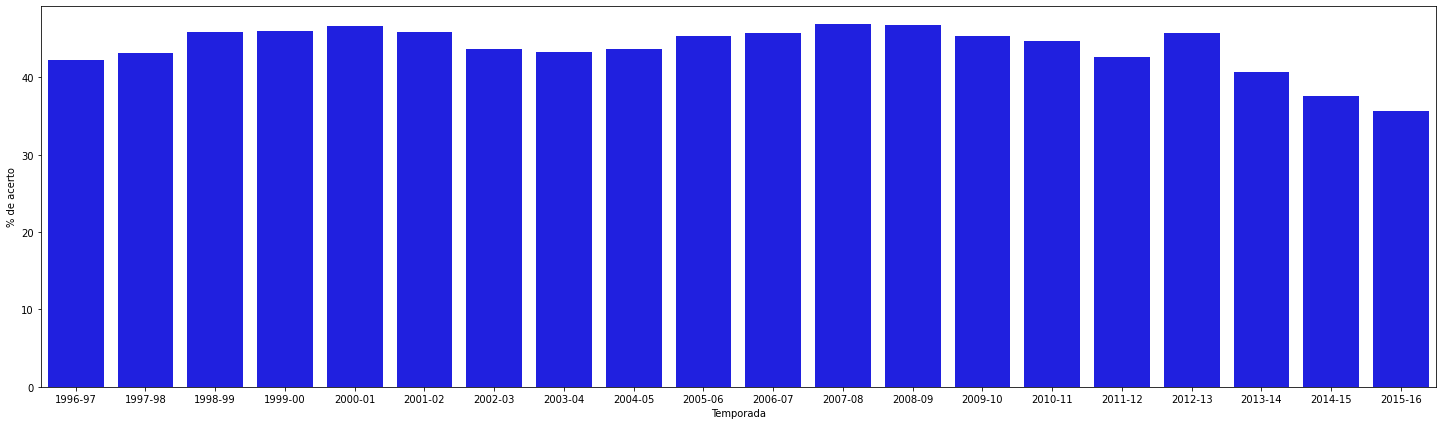

In [ ]:
# https://www.kaggle.com/zeyufeng/kobe-s-shot-analysis
fig = plt.figure(figsize=(25,7))
df_pct = df[df['shot_made_flag'] == 1].groupby(['season']).count() / df.groupby(['season']).count()
df_pct = pd.DataFrame({'Temporada': df_pct.index, '% de acerto': df_pct.max(axis=1)}).reset_index(drop=True)
sns.barplot(x=df_pct['Temporada'], y=100 * df_pct['% de acerto'], color='blue')
plt.show()

### Questão 2 - Como foi o aproveitamento de seus arremessos nos anos em que foi campeão em relação aos demais?

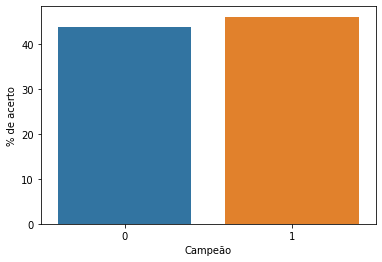

In [ ]:
championship_seasons = ['1999-00', '2000-01', '2001-02', 
                        '2008-09', '2009-10']
df['championship_season'] = df['season'].apply(lambda x: 1 if x in championship_seasons else 0)
# df.groupby(['season', 'championship_season']).count()
df_pct_campeonato = 100 * df[df['shot_made_flag'] == 1].groupby(['championship_season']).count().max(axis=1) / df.groupby(['championship_season']).count().max(axis=1)
df_pct_campeonato = pd.DataFrame({'Campeão': df_pct_campeonato.index, '% de acerto': df_pct_campeonato.values})
sns.barplot(x=df_pct_campeonato['Campeão'], y=df_pct_campeonato['% de acerto'])
plt.show()

### Questão 3 - Existem regiões da quadra onde o Kobe era "dominante"?

In [ ]:
def draw_court(ax=None, color='black', lw=2, outer_lines=False):
    if ax is None:
        ax = plt.gca()

    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)

    backboard = Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=color)

    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color,
                          fill=False)
    
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color,
                          fill=False)

    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False)
    
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed')
    
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw,
                     color=color)

    corner_three_a = Rectangle((-220, -47.5), 0, 140, linewidth=lw,
                               color=color)
    
    corner_three_b = Rectangle((220, -47.5), 0, 140, linewidth=lw, color=color)
    
    three_arc = Arc((0, 0), 475, 475, theta1=22, theta2=158, linewidth=lw,
                    color=color)

    center_outer_arc = Arc((0, 422.5), 120, 120, theta1=180, theta2=0,
                           linewidth=lw, color=color)
    center_inner_arc = Arc((0, 422.5), 40, 40, theta1=180, theta2=0,
                           linewidth=lw, color=color)

    court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                      bottom_free_throw, restricted, corner_three_a,
                      corner_three_b, three_arc, center_outer_arc,
                      center_inner_arc]

    if outer_lines:
        outer_lines = Rectangle((-250, -47.5), 500, 470, linewidth=lw,
                                color=color, fill=False)
        court_elements.append(outer_lines)

    for element in court_elements:
        ax.add_patch(element)

    return ax

def Draw2DGaussians(gaussianMixtureModel, ellipseColors, ellipseTextMessages):
    
    fig, h = plt.subplots();
    for i, (mean, covarianceMatrix) in enumerate(zip(gaussianMixtureModel.means_, gaussianMixtureModel.covariances_)):
        
        v, w = np.linalg.eigh(covarianceMatrix)
        v = 2.5*np.sqrt(v)
        
        u = w[0] / np.linalg.norm(w[0])    
        angle = np.arctan(u[1] / u[0])
        angle = 180 * angle / np.pi 
        currEllipse = mpl.patches.Ellipse(mean, v[0], v[1], 180 + angle, color=ellipseColors[i])
        currEllipse.set_alpha(0.5)
        h.add_artist(currEllipse)
        h.text(mean[0]+7, mean[1]-1, ellipseTextMessages[i], fontsize=13, color='blue')

In [ ]:
# definir clusters por região da quadra
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=15, random_state=42)
clusters = kmeans.fit_predict(df[['loc_x', 'loc_y']])
df['cluster_regiao'] = clusters

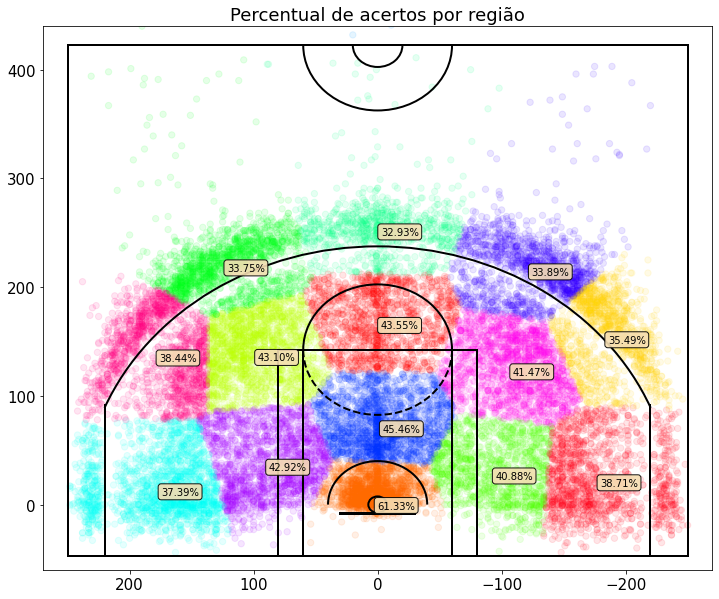

In [ ]:
# criando percentual de acerto por região da quadra
plt.rcParams['font.size'] = 15

# fig, ax = plt.subplots()
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111)
draw_court(outer_lines=True)
plt.ylim(-60,440)
plt.xlim(270,-270)
plt.title('Percentual de acertos por região')
plt.scatter(x = df['loc_x'], 
            y = df['loc_y'], 
            c = df['cluster_regiao'], 
            s = 40, cmap = 'hsv', alpha = 0.1)

# plotando os percentuais
props = dict(boxstyle='round', facecolor='wheat', alpha=0.9)
for ix_cluster, pos in zip(range(15), kmeans.cluster_centers_):
  if pos[1] < 400:
    pct_cluster = 100.0 * df[(df['cluster_regiao'] == ix_cluster) & (df['shot_made_flag'] == 1)].count().max() / df[df['cluster_regiao'] == ix_cluster].count().max()
    ax.text(pos[0], pos[1], f'{pct_cluster:.2f}%', 
            fontsize=10, 
            verticalalignment='top', 
            bbox=props)
  # 0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        # verticalalignment='top', bbox=props
plt.show()


### Questão 4 - É possível prever se ele acerta/erra um arremesso dadas as informações disponíveis?

In [ ]:
#criando modelo
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
dt = DecisionTreeClassifier(random_state=42)

df_modelo = pd.get_dummies(df.drop('championship_season', axis=1), drop_first=True)
X, y = df_modelo.drop('shot_made_flag', axis=1), df_modelo['shot_made_flag']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
dt.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [ ]:
# avaliando modelo
y_pred = dt.predict(X_test)

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
print(f'Tx de acerto = {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))

Tx de acerto = 0.6010376134889753
              precision    recall  f1-score   support

         0.0       0.63      0.67      0.65      4283
         1.0       0.55      0.52      0.54      3427

    accuracy                           0.60      7710
   macro avg       0.59      0.59      0.59      7710
weighted avg       0.60      0.60      0.60      7710



### Questão 5 - Quais características parecem ser mais relevantes para determinar se ele acertava ou errava um arremesso?

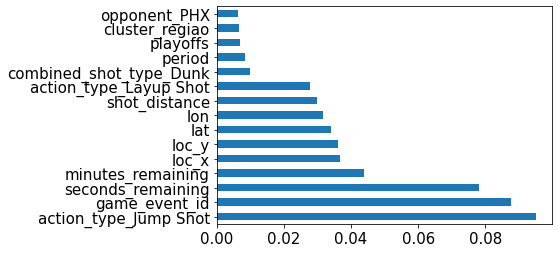

In [ ]:
importancias = pd.Series(dt.feature_importances_, index=X_train.columns.values)
importancias.sort_values(ascending=False).nlargest(15).plot(kind='barh')

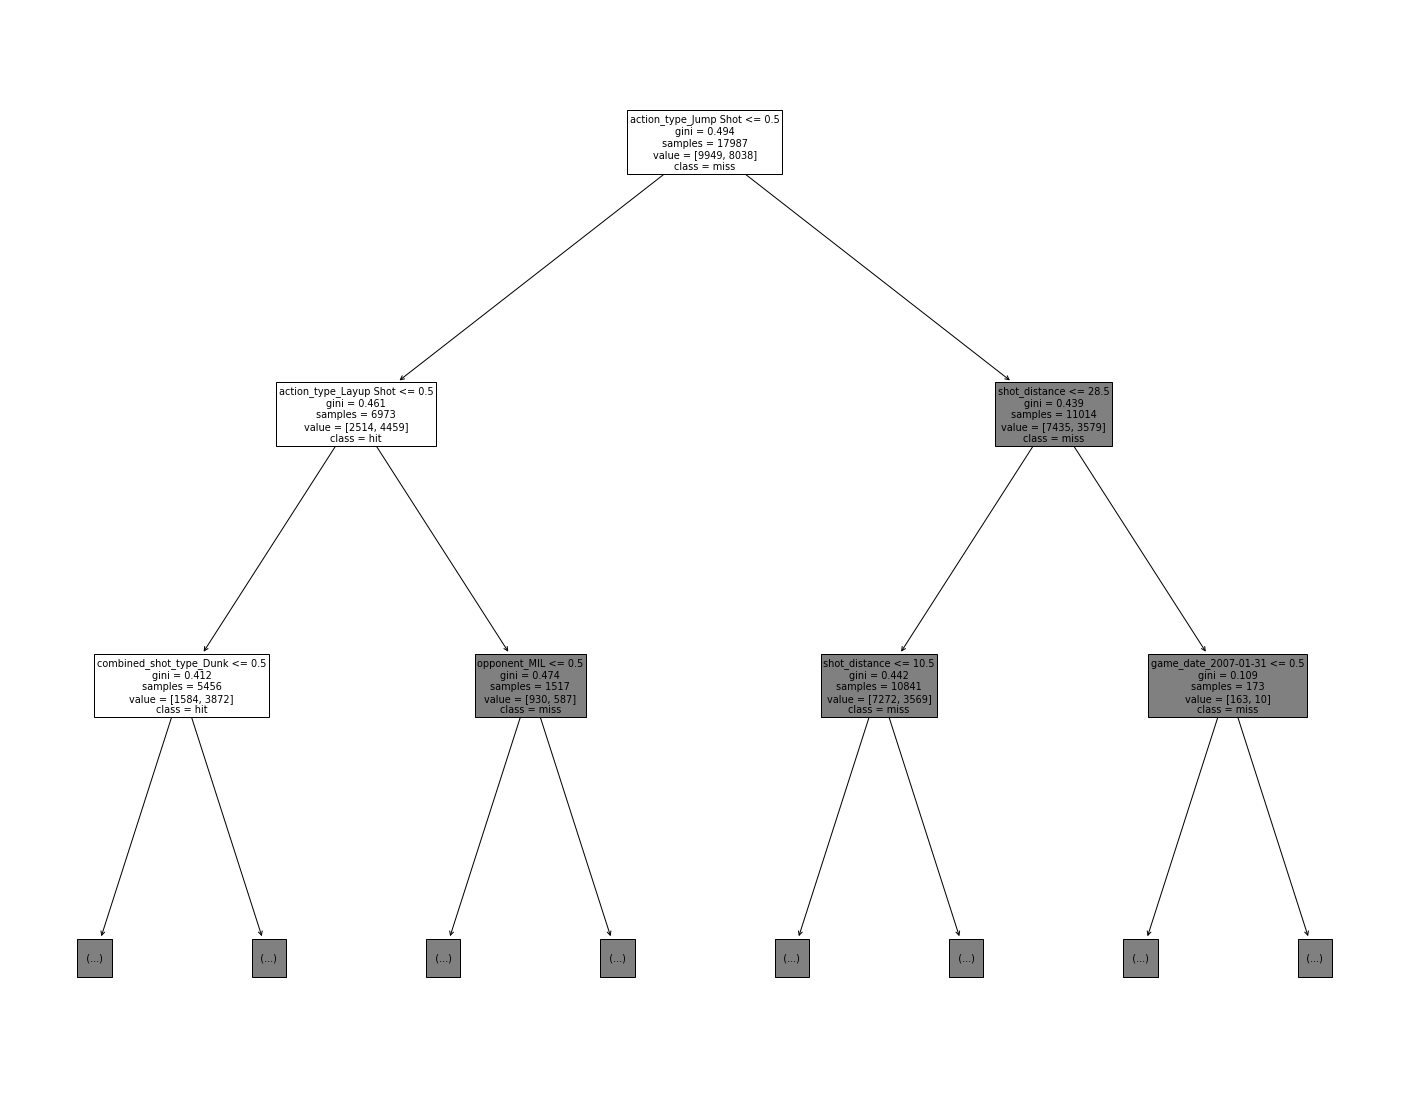

In [ ]:
from sklearn import tree
fig = plt.figure(figsize=(25,20))
tree.plot_tree(dt, max_depth=2, feature_names=X_train.columns.values, class_names=['miss', 'hit'])
plt.show()

## Sistemas de Recomendação

In [ ]:
# instalacao da biblioteca
!pip install surprise

     |████████████████████████████████| 11.8 MB 52 kB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1619388 sha256=14bbe57a0a5dec7a71398a500abc56b3d57b9d3c4567e2a07dfcc4700dae3689
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [ ]:
#importando modelos
from surprise import SVD
from surprise import KNNBasic
from surprise import NMF
#importando bases de dados
from surprise import Dataset
from surprise.model_selection import train_test_split
# importando metricas de avaliacao
from surprise import accuracy


# Realizando download dos dados
data = Dataset.load_builtin('ml-100k')
# data = Dataset.load_builtin('ml-1m')

Dataset ml-100k could not be found. Do you want to download it? [Y/n] y
Trying to download dataset from http://files.grouplens.org/datasets/movielens/ml-100k.zip...
Done! Dataset ml-100k has been saved to /root/.surprise_data/ml-100k


In [ ]:
data.raw_ratings[:5]

[('196', '242', 3.0, '881250949'),
 ('186', '302', 3.0, '891717742'),
 ('22', '377', 1.0, '878887116'),
 ('244', '51', 2.0, '880606923'),
 ('166', '346', 1.0, '886397596')]

In [ ]:
# dividindo os dados em treinamento e teste
trainset, testset = train_test_split(data, test_size=.25)

# criacao dos algoritmos
svd = SVD()
knn = KNNBasic()
nmf = NMF()

# Treinamento dos modelos
svd.fit(trainset)
knn.fit(trainset)
nmf.fit(trainset)

# previsao dos modelos
predictions_svd = svd.test(testset)
predictions_knn = knn.test(testset)
predictions_nmf = nmf.test(testset)


# Calculo das metricas de avaliacao
print('-' * 30)
accuracy.rmse(predictions_svd)
print('-' * 30)
accuracy.rmse(predictions_knn)
print('-' * 30)
accuracy.rmse(predictions_nmf)
print('-' * 30)

Computing the msd similarity matrix...
Done computing similarity matrix.
------------------------------
RMSE: 0.9372
------------------------------
RMSE: 0.9772
------------------------------
RMSE: 0.9654
------------------------------


In [ ]:
uid = str(100)  # id do usuario
iid = str(150) # id do item

# obtendo a previsao de um usuario em relacao a um item
pred = svd.predict(uid, iid, verbose=True)

user: 100        item: 150        r_ui = None   est = 3.73   {'was_impossible': False}
